
Training for aspect: look
Aspect: look, Epoch: 1, Loss: 12.8728
Aspect: look, Epoch: 2, Loss: 12.6922
Aspect: look, Epoch: 3, Loss: 12.5078

Evaluation for look:
MAE: 3.4013
MSE: 12.4788
R2 Score: -12.7183


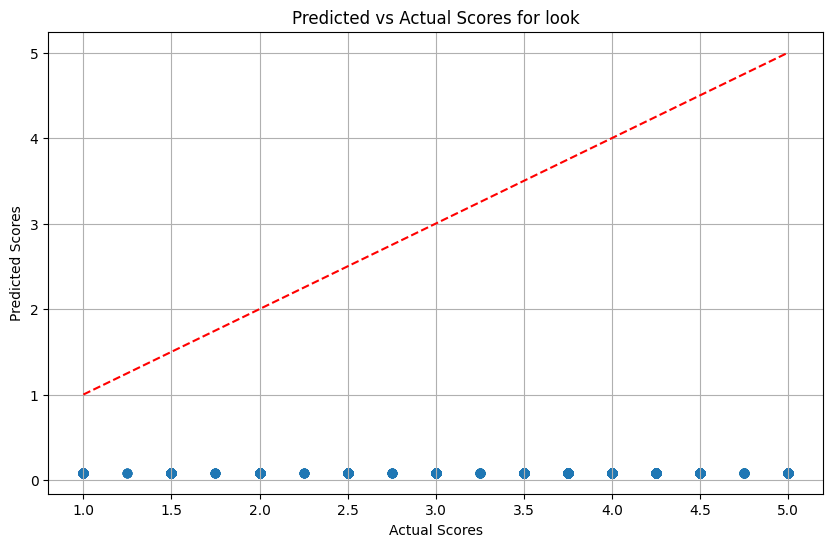


Training for aspect: smell
Aspect: smell, Epoch: 1, Loss: 10.9101
Aspect: smell, Epoch: 2, Loss: 10.7457
Aspect: smell, Epoch: 3, Loss: 10.5855

Evaluation for smell:
MAE: 3.0007
MSE: 10.3780
R2 Score: -6.5543


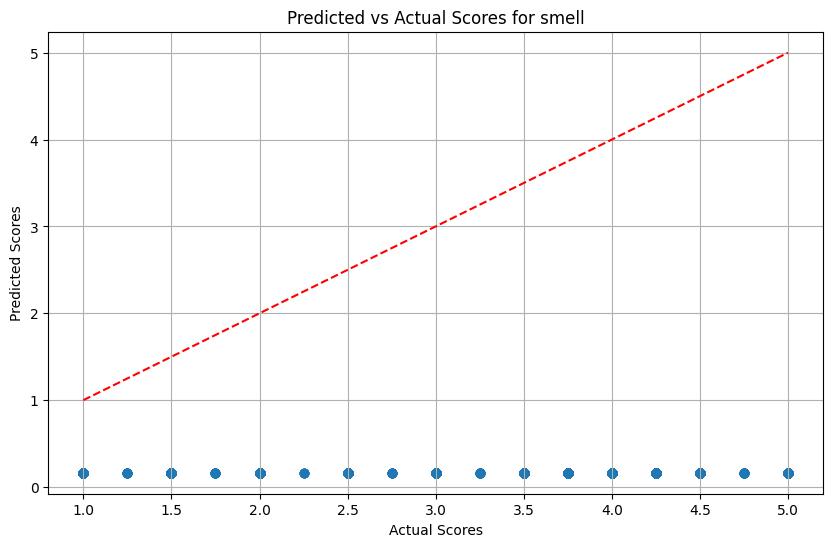


Training for aspect: taste
Aspect: taste, Epoch: 1, Loss: 10.2342
Aspect: taste, Epoch: 2, Loss: 10.0816
Aspect: taste, Epoch: 3, Loss: 9.9229

Evaluation for taste:
MAE: 2.8469
MSE: 9.7600
R2 Score: -4.8960


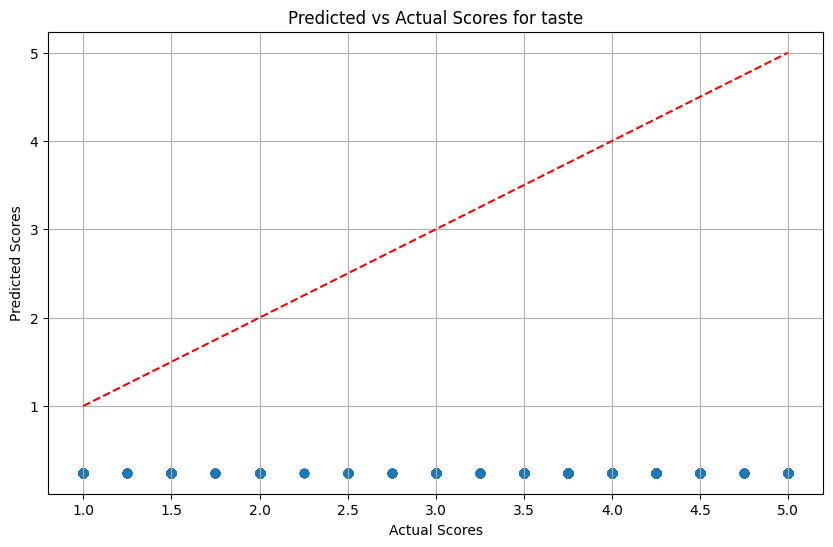


Training for aspect: feel
Aspect: feel, Epoch: 1, Loss: 10.0794
Aspect: feel, Epoch: 2, Loss: 9.9203
Aspect: feel, Epoch: 3, Loss: 9.7651

Evaluation for feel:
MAE: 2.8968
MSE: 9.6533
R2 Score: -6.6507


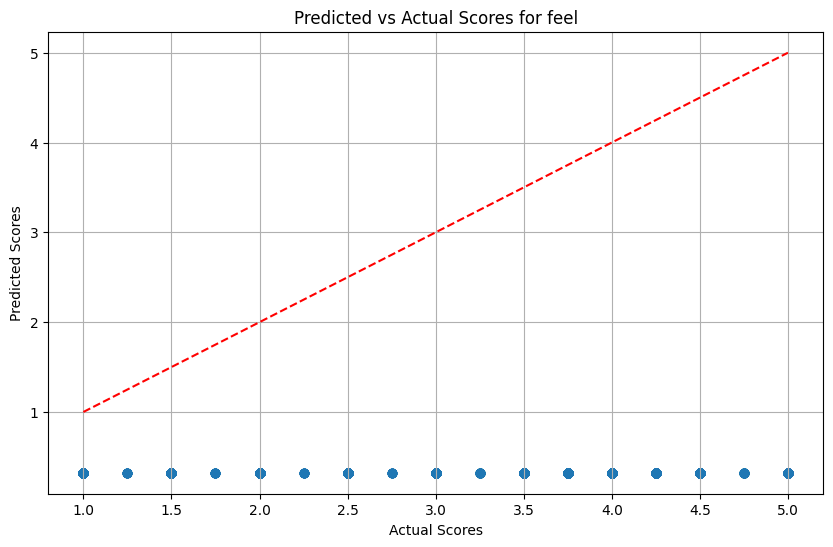


Sample review analysis:
look: 3.32
smell: 3.32
taste: 3.32
feel: 3.32


In [6]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

class BeerReviewDataset(Dataset):
    """
    Custom Dataset class for beer reviews
    Handles text and aspect scores for look, smell, taste, and feel
    """
    def __init__(self, texts, aspects, scores, tokenizer, max_length=128):
        self.texts = texts
        self.aspects = aspects
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        aspect = self.aspects[idx]
        score = self.scores[idx]
        
        # Combine text and aspect for model input
        combined_text = f"{aspect}: {text}"
        
        # Tokenize the combined text
        encoding = self.tokenizer(
            combined_text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'score': torch.tensor(score, dtype=torch.float)
        }

class AspectBasedSentimentAnalyzer:
    """
    Main class for aspect-based sentiment analysis of beer reviews
    """
    def __init__(self, model_name="stevhliu/my_awesome_model"):
        # Initialize model and tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        # Define aspects for beer reviews
        self.aspects = ['look', 'smell', 'taste', 'feel']
        
    def prepare_data(self, df):
        """
        Prepare data for training/testing
        Args:
            df: DataFrame with columns ['text', 'look', 'smell', 'taste', 'feel']
        """
        # Create separate datasets for each aspect
        self.datasets = {}
        for aspect in self.aspects:
            # Filter out NaN scores for current aspect
            mask = ~df[aspect].isna()
            texts = df.loc[mask, 'text'].values
            scores = df.loc[mask, aspect].values
            
            # Split into train/test sets
            train_texts, test_texts, train_scores, test_scores = train_test_split(
                texts, scores, test_size=0.2, random_state=42
            )
            
            # Create datasets
            train_dataset = BeerReviewDataset(
                train_texts,
                [aspect] * len(train_texts),
                train_scores,
                self.tokenizer
            )
            test_dataset = BeerReviewDataset(
                test_texts,
                [aspect] * len(test_texts),
                test_scores,
                self.tokenizer
            )
            
            self.datasets[aspect] = {
                'train': train_dataset,
                'test': test_dataset
            }
    
    def train(self, aspect, batch_size=32, epochs=3, learning_rate=2e-5):
        """
        Train the model for a specific aspect
        """
        train_loader = DataLoader(
            self.datasets[aspect]['train'],
            batch_size=batch_size,
            shuffle=True
        )
        
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        criterion = torch.nn.MSELoss()
        
        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                scores = batch['score'].to(self.device)
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                # Use [CLS] token output for prediction
                predictions = outputs.last_hidden_state[:, 0, :].mean(dim=1)
                loss = criterion(predictions, scores)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(train_loader)
            print(f"Aspect: {aspect}, Epoch: {epoch+1}, Loss: {avg_loss:.4f}")
    
    def evaluate(self, aspect):
        """
        Evaluate the model for a specific aspect
        """
        test_loader = DataLoader(
            self.datasets[aspect]['test'],
            batch_size=32,
            shuffle=False
        )
        
        self.model.eval()
        predictions = []
        actual_scores = []
        
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                scores = batch['score']
                
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                preds = outputs.last_hidden_state[:, 0, :].mean(dim=1).cpu()
                predictions.extend(preds.numpy())
                actual_scores.extend(scores.numpy())
        
        # Calculate metrics
        mae = mean_absolute_error(actual_scores, predictions)
        mse = mean_squared_error(actual_scores, predictions)
        r2 = r2_score(actual_scores, predictions)
        
        print(f"\nEvaluation for {aspect}:")
        print(f"MAE: {mae:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"R2 Score: {r2:.4f}")
        
        return predictions, actual_scores
    
    def analyze_review(self, text):
        """
        Analyze a single review for all aspects
        """
        self.model.eval()
        results = {}
        
        with torch.no_grad():
            for aspect in self.aspects:
                # Prepare input
                combined_text = f"{aspect}: {text}"
                inputs = self.tokenizer(
                    combined_text,
                    truncation=True,
                    padding='max_length',
                    max_length=128,
                    return_tensors='pt'
                ).to(self.device)
                
                # Get prediction
                outputs = self.model(**inputs)
                prediction = outputs.last_hidden_state[:, 0, :].mean(dim=1)
                
                # Convert to 1-5 scale
                score = torch.sigmoid(prediction) * 4 + 1
                results[aspect] = round(score.item(), 2)
        
        return results

def plot_results(predictions, actual_scores, aspect):
    """
    Plot prediction vs actual scores
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_scores, predictions, alpha=0.5)
    plt.plot([1, 5], [1, 5], 'r--')
    plt.xlabel('Actual Scores')
    plt.ylabel('Predicted Scores')
    plt.title(f'Predicted vs Actual Scores for {aspect}')
    plt.grid(True)
    plt.show()

# Example usage
if __name__ == "__main__":
    # Load preprocessed data
    df = pd.read_csv('../data/reviews_undersampled_dataset.csv')
    
    # Initialize analyzer
    analyzer = AspectBasedSentimentAnalyzer()
    
    # Prepare data
    analyzer.prepare_data(df)
    
    # Train and evaluate for each aspect
    for aspect in analyzer.aspects:
        print(f"\nTraining for aspect: {aspect}")
        analyzer.train(aspect)
        predictions, actual_scores = analyzer.evaluate(aspect)
        plot_results(predictions, actual_scores, aspect)
    
    # Example review analysis
    sample_review = "This beer has a beautiful golden color with a nice head. The aroma is fruity and hoppy. The taste is well-balanced with a slight bitterness. The mouthfeel is smooth and creamy."
    results = analyzer.analyze_review(sample_review)
    print("\nSample review analysis:")
    for aspect, score in results.items():
        print(f"{aspect}: {score}")